# Kalman Filtering Investigation

This notebook investigates whether the use of a kalman filter for speed estimation works or not.

This will be done by first defining a test "true" speed and cadence profile. From this "true" profile, quantized data that simulates the bluetooth sensors (one "tick" per revolution) will be created. The Kalman filter will then be tested against this simulated quantized data to compare the Kalman filter's estimate with the "true" data.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.optimize
import random
import numba


matplotlib.rcParams['figure.figsize'] = (18, 16)

In [3]:
ROLLING_LENGTH = 2096.
DT = 0.25


# Generate Speed and Cadence Data

We'll create some functions for generating speed and cadence data.

In [4]:
def generate_segment(t0, time, start_speed, end_speed):
    data = pd.DataFrame({
        "t": pd.Series(np.arange(t0, t0 + time, step=DT, dtype=np.float))
    })
    data = data.assign(
        V=np.linspace(start_speed, end_speed, num=len(data))
    )
    data = data.assign(
        V=[max(v, 0) for v in data.V]
    )
    return data


def generate_cadence(omega: pd.Series) -> (np.ndarray, np.ndarray, np.ndarray):
    #  Take the number of teeth from a Trek Emonda SLR 9
    rear = [11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 28]
    front = [50, 34]
    target_cadence = 80 / 60  # revs/sec
    cadence_range = 30 / 60
    cur_i_front = 1
    cur_i_rear = 5
    
    front_gear = np.zeros(len(omega))
    rear_gear = np.zeros(len(omega))
    crank_speed = np.zeros(len(omega))
    
    for i, om in np.ndenumerate(omega.values):  # units: revs/s
        front_gear[i] = cur_i_front
        rear_gear[i] = cur_i_rear
        crank_speed[i] = om * rear[cur_i_rear] / front[cur_i_front]
        # Adjust the front chain ring position, if needed
        if cur_i_rear < (len(rear) / 2 - 2) and cur_i_front == 1:
            cur_i_front = 0
        elif cur_i_rear > (len(rear) / 2 + 2) and cur_i_front == 0:
            cur_i_front = 1
        else:
            cadence_deviation = crank_speed[i] - target_cadence
            shift_probability = (cadence_deviation / cadence_range) ** 2
            if random.random() < shift_probability:
                cur_i_rear = cur_i_rear - 1 if cadence_deviation > 0 else cur_i_rear + 1
                cur_i_rear = min(len(rear) - 1, cur_i_rear)
                cur_i_rear = max(0, cur_i_rear)
    
    return crank_speed, front_gear, rear_gear


def generate_simulation():
    n_segments = random.randint(5, 10)
    speed = 0
    time = 0
    data = pd.DataFrame()
    for i in range(n_segments):
        if random.choice([True, False]) or n_segments == 0:
            #  Change the speed for this segment
            new_speed = random.uniform(0, 40)
            # limit the acceleration to 0.5 m/s (note, speed is in km/h)
            segment_time = abs(new_speed - speed) / 0.5 * 3.6 * random.uniform(0, 1)
            seg = generate_segment(time, segment_time, speed, new_speed)
            speed = new_speed
        else:
            #  Keep the speed constant for this segment
            segment_time = random.uniform(10, 200)
            seg = generate_segment(time, segment_time, speed, speed)
        data = pd.concat([data, seg])
        time = time + segment_time
    
    data.reset_index()
    
    #  add a columns for wheel speed, wheel rotations and measured wheel rotations
    data = data.assign(
        omega=[V * 1e+6 / ROLLING_LENGTH / 3600. for V in data.V]  # revs/s
    )
    data = data.assign(
        N=np.insert(integrate.cumtrapz(data.omega, data.t), 0, 0)
    )
    data = data.assign(
        N_meas=[np.floor(N) for N in data.N]
    )
    crank_speed, front_gear, rear_gear = generate_cadence(data.omega)
    data["crank_speed"] = crank_speed
    data["front_gear"] = front_gear
    data["rear_gear"] = rear_gear
    data = data.assign(
        crank_rots=np.insert(integrate.cumtrapz(data.crank_speed, data.t), 0, 0)
    )
    data = data.assign(
        crank_meas=[np.float(cr) for cr in data.crank_rots]
    )
    return data

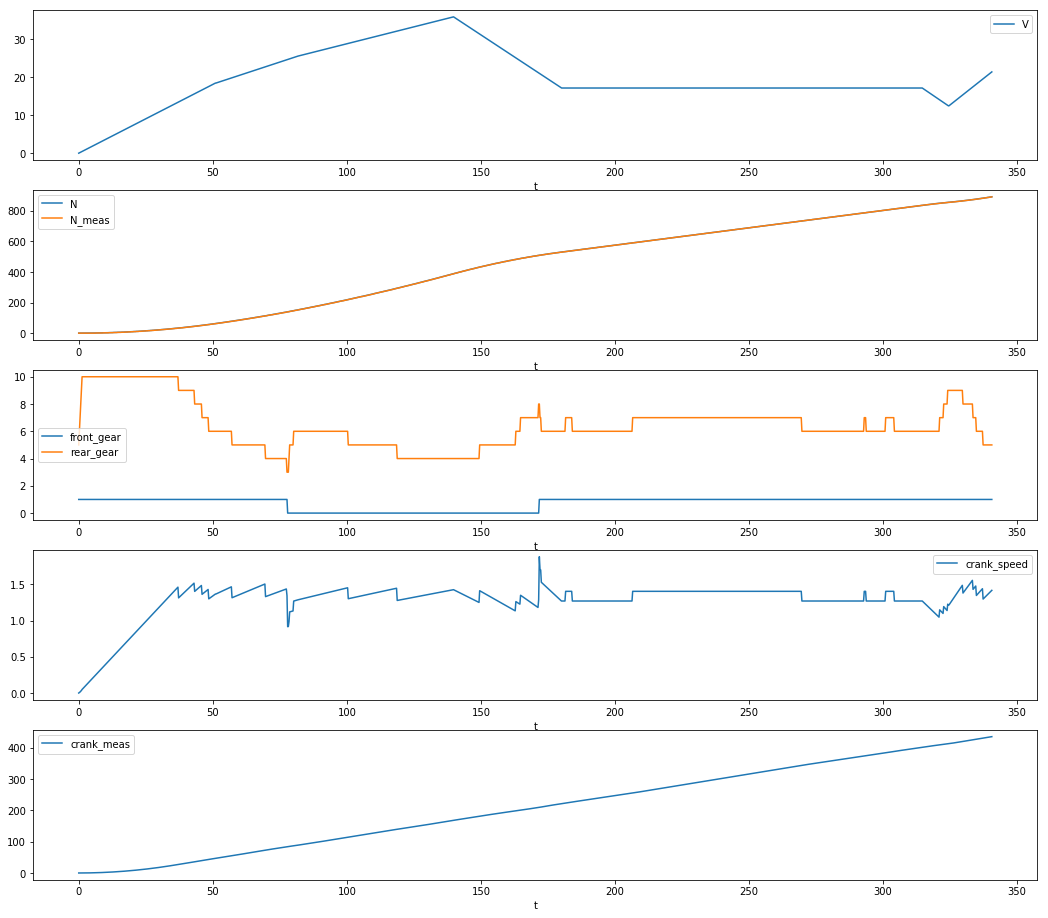

In [5]:
random.seed(23456)  # make this example reproducible
sim_data1 = generate_simulation()
fig, ax = plt.subplots(nrows=5, facecolor="white")
sim_data1.plot(ax=ax[0], x='t', y='V')
sim_data1.plot(ax=ax[1], x='t', y='N')
sim_data1.plot(ax=ax[1], x='t', y='N_meas')
sim_data1.plot(ax=ax[2], x='t', y="front_gear")
sim_data1.plot(ax=ax[2], x='t', y='rear_gear')
sim_data1.plot(ax=ax[3], x='t', y='crank_speed')
sim_data1.plot(ax=ax[4], x='t', y='crank_meas')

Now that we have a way of randomly generating profiles, we'll create a bunch of them. We'll use a certain fraction of these profiles to set the hyperparameters of the Kalman filter, and use the rest of them to validate these hyperparameters (similar to training and validation sets used in machine learning)

In [6]:
random.seed(23456)  # make this example reproducible

NUM_SIM = 10

sim_data = [generate_simulation() for i in range(NUM_SIM)]  # TODO: Increase this number


The plot below shows a few of the profiles generated.

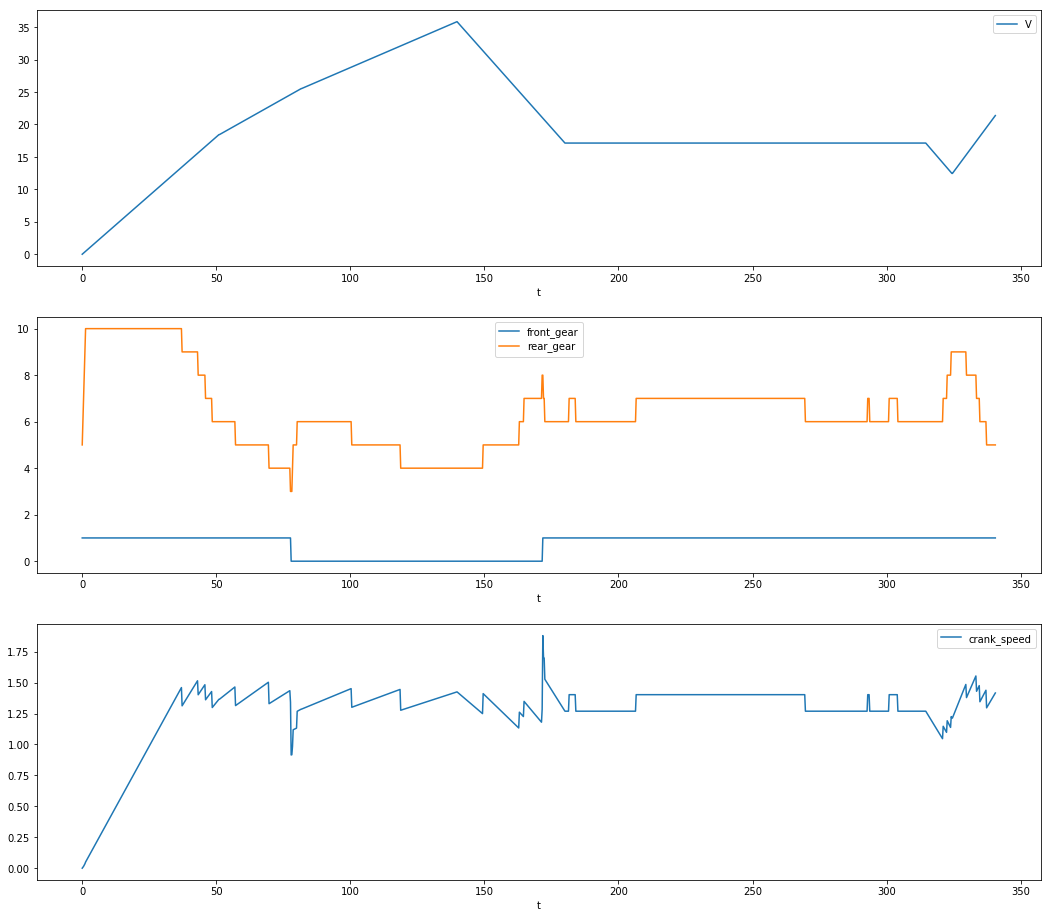

In [7]:
fig, ax = plt.subplots(nrows=3, facecolor="white")

for i, sd in enumerate(sim_data):
    if i % 100 == 0:
        sd.plot(ax=ax[0], x='t', y="V")
        sd.plot(ax=ax[1], x='t', y="front_gear")
        sd.plot(ax=ax[1], x='t', y='rear_gear')
        sd.plot(ax=ax[2], x='t', y='crank_speed')

# Kalman Filter

In general, Kalman filter requires a model with a state update function of the form:

$$
x_{k} = A x_{k-1} + B u_{k-1} + w_{k-1}
$$

The system modelled has an output of the form:

$$
z_k = H x_k + v_k
$$

$x_k$ is the state variable, $z_k$ is the output variable, $u_k$ is the input variable, and $w_k$ and $v_k$ are zero-mean white Gaussian additive noises, defined as follows:

$$
w \sim N\left( 0, Q \right)
$$

$$
v \sim N\left( 0, R \right)
$$

In our case, out state variable has two components: the rotation count, and the speed. Thus, the state update function is:

$$
x_{k} = \begin{bmatrix}N_{k} \\ \omega_{k}\end{bmatrix} = \begin{bmatrix}1 & \Delta T \\ 0 & \omega_k\end{bmatrix} \begin{bmatrix}N_{k-1} \\ \omega_{k-1}\end{bmatrix} 
$$

The Kalman filter is implemented as follows:

$$
\hat{x}_{k}^{-} = A \hat{x}_{k-1}
$$

$$
P_k^{-} = A P_{k-1} A^T + Q
$$

$$
K_k = \frac{P_k^{-} H^T}{H P_k^{-} H^T + R}
$$

$$
\hat{x}_k = \hat{x}_{k}^{-} + K_k \left( z_k - H \hat{x}_{k}^{-} \right)
$$

$$
P_k = \left( I - K_k H \right) P_k^{-}
$$

As a first estimate of $R$, we can find the mean and variance of the difference between the measured and actual measurement.

In [8]:
np.mean(sim_data[0].N - sim_data[0].N_meas)

0.49540320781055136

In [9]:
np.std(sim_data[0].N - sim_data[0].N_meas) ** 2

0.08571091591140308

These match the analytical solution, which shows that the mean is $0.5$ and the variance is $1 / 12$.

In [10]:
@numba.jit(
    "f8[:,:](f8[:],f8,f8[:,:],f8)",
    nopython=True
)
def kalman1(z_data, dt, Q, R):
    A = np.zeros((2, 2), dtype=np.float64)
    A[0, 0] = 1.
    A[0, 1] = dt
    A[1, 0] = 0.
    A[1, 1] = 1.
    
    H = np.zeros((1, 2), dtype=np.float64)
    H[0, 0] = 1.
    H[0, 1] = 0
    
    # Initialize the variables
    x_hat = np.zeros((2, 1), dtype=np.float64)
    x_hat[0, 0] = z_data[0]
    x_hat[1, 0] = 0.
    # x_hat = np.array([[z_data[0], 0.]], dtype=np.float64).T
    P = np.zeros((2, 2), dtype=np.float64)
    P[0, 0] = 1.
    P[0, 1] = 0.
    P[1, 0] = 0.
    P[1, 1] = 1.
    # P = np.array([[1., 0.], [0., 1.]], dtype=np.float64)
    
    I2 = np.zeros((2, 2), dtype=np.float64)
    I2[0, 0] = 1.
    I2[0, 1] = 0.
    I2[1, 0] = 0.
    I2[1, 1] = 1.
    
    x_store = np.zeros((len(z_data), 2), dtype=np.float64)
    
    for i, z in enumerate(z_data):
        x_hatminus = np.dot(A, x_hat)  # 2x1
        P_minus = np.dot(np.dot(A, P), A.T) + Q  # 2x2
        K = np.dot(P_minus, H.T) / (np.dot(np.dot(H, P_minus), H.T) + R)  # 2x1
        x_hat = x_hatminus + K * (z - 0.5 - np.dot(H, x_hatminus))  # the 0.5 makes it unbiased
        P = (I2 - K * H) * P_minus
        x_store[i, :] = x_hat.T
    
    return x_store

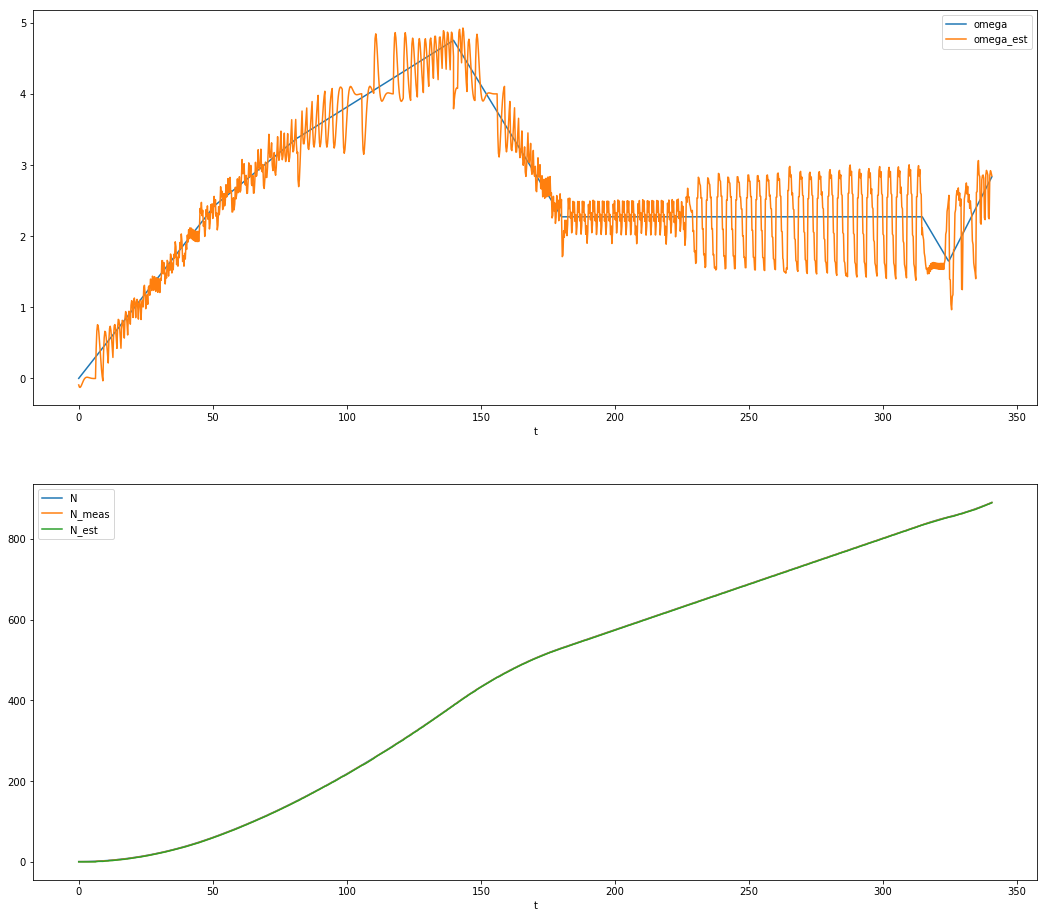

In [11]:
res = kalman1(
    sim_data[0].N_meas.values, 
    DT, 
    Q=np.array([[0.0001, 0.1], [0.0001, 100]]) / 100000,
    R=np.sqrt(1/12)
)
kalman1_result = sim_data[0].assign(N_est=res[:, 0]).assign(omega_est=res[:, 1])

fig, ax = plt.subplots(nrows=2, facecolor="white")
kalman1_result.plot(ax=ax[0], x='t', y="omega")
kalman1_result.plot(ax=ax[0], x='t', y="omega_est")
kalman1_result.plot(ax=ax[1], x='t', y="N")
kalman1_result.plot(ax=ax[1], x="t", y="N_meas")
kalman1_result.plot(ax=ax[1], x="t", y="N_est")

We can try to optimize the parameters $Q$ and $R$. To do so, we'll first define a loss function. We'll use RMS error.


In [12]:
@numba.jit(
    "f8(f8[:],f8[:])",
    nopython=True
)
def loss_fcn(speed_actual, speed_estimated):
    return np.sqrt(np.sum((speed_actual - speed_estimated) ** 2))


loss_fcn(kalman1_result.omega.values, kalman1_result.omega_est.values)

12.750347760869234

From here, we can optimize the parameters $Q$ and $R$. We'll use the first half of the generated speed profiles to optimize, then calculate the loss function on the other half with the parameters $Q$ and $R$ fixed.

In [13]:
@numba.jit(
    "f8(b1,f8[:,:],f8)",
    parallel=True
)
def loss_fcn_multi(second_half: bool, Q: np.ndarray, R: float) -> float:
    loss = np.zeros(NUM_SIM, dtype=np.float64)
    for i in numba.prange(NUM_SIM):
        if i < (NUM_SIM / 2) != second_half:
            sim = sim_data[i]
            kalman_res = kalman1(sim.N_meas.values, DT, Q, R)
            loss[i] = loss_fcn(sim.omega.values, kalman_res[:, 1])
    return loss.sum()

 final_simplex: (array([[ 1.18528752e-10,  2.57697267e-06, -3.51400602e-09,
        -3.39040579e-05,  2.51927702e+00],
       [ 1.18469589e-10,  2.57703581e-06, -3.51411785e-09,
        -3.39073138e-05,  2.51932384e+00],
       [ 1.18478899e-10,  2.57703676e-06, -3.51413867e-09,
        -3.39056775e-05,  2.51933452e+00],
       [ 1.18522472e-10,  2.57694273e-06, -3.51385088e-09,
        -3.39198770e-05,  2.51920959e+00],
       [ 1.18483353e-10,  2.57700156e-06, -3.51402554e-09,
        -3.38972025e-05,  2.51928504e+00],
       [ 1.18513622e-10,  2.57693944e-06, -3.51383606e-09,
        -3.39273659e-05,  2.51920598e+00]]), array([15.76851798, 15.76851798, 15.76851799, 15.76851799, 15.76851799,
       15.76851799]))
           fun: 15.768517984457846
       message: 'Optimization terminated successfully.'
          nfev: 248
           nit: 140
        status: 0
       success: True
             x: array([ 1.18528752e-10,  2.57697267e-06, -3.51400602e-09, -3.39040579e-05,
        2.5192

In [14]:
loss_fcn_multi(False, Q=np.array([[0.0001, 0.1], [0.0001, 100]]) / 100000, R=np.sqrt(1/12))

91.15495914179279

In [18]:
scipy.optimize.minimize(
    lambda x: loss_fcn_multi(False,
                Q=np.reshape(x[0:4], (2, 2)),
                R=x[4]
    ),
    x0=np.array([0.000000001, 0.000001, 0.000000001, 0.001, np.sqrt(1/12)]),
    # bounds=((0, None), (0, None), (0, None), (0, None), (0, None)),
    method="Nelder-Mead"
)


 final_simplex: (array([[ 1.18528752e-10,  2.57697267e-06, -3.51400602e-09,
        -3.39040579e-05,  2.51927702e+00],
       [ 1.18469589e-10,  2.57703581e-06, -3.51411785e-09,
        -3.39073138e-05,  2.51932384e+00],
       [ 1.18478899e-10,  2.57703676e-06, -3.51413867e-09,
        -3.39056775e-05,  2.51933452e+00],
       [ 1.18522472e-10,  2.57694273e-06, -3.51385088e-09,
        -3.39198770e-05,  2.51920959e+00],
       [ 1.18483353e-10,  2.57700156e-06, -3.51402554e-09,
        -3.38972025e-05,  2.51928504e+00],
       [ 1.18513622e-10,  2.57693944e-06, -3.51383606e-09,
        -3.39273659e-05,  2.51920598e+00]]), array([15.76851798, 15.76851798, 15.76851799, 15.76851799, 15.76851799,
       15.76851799]))
           fun: 15.768517984457846
       message: 'Optimization terminated successfully.'
          nfev: 248
           nit: 140
        status: 0
       success: True
             x: array([ 1.18528752e-10,  2.57697267e-06, -3.51400602e-09, -3.39040579e-05,
        2.5192

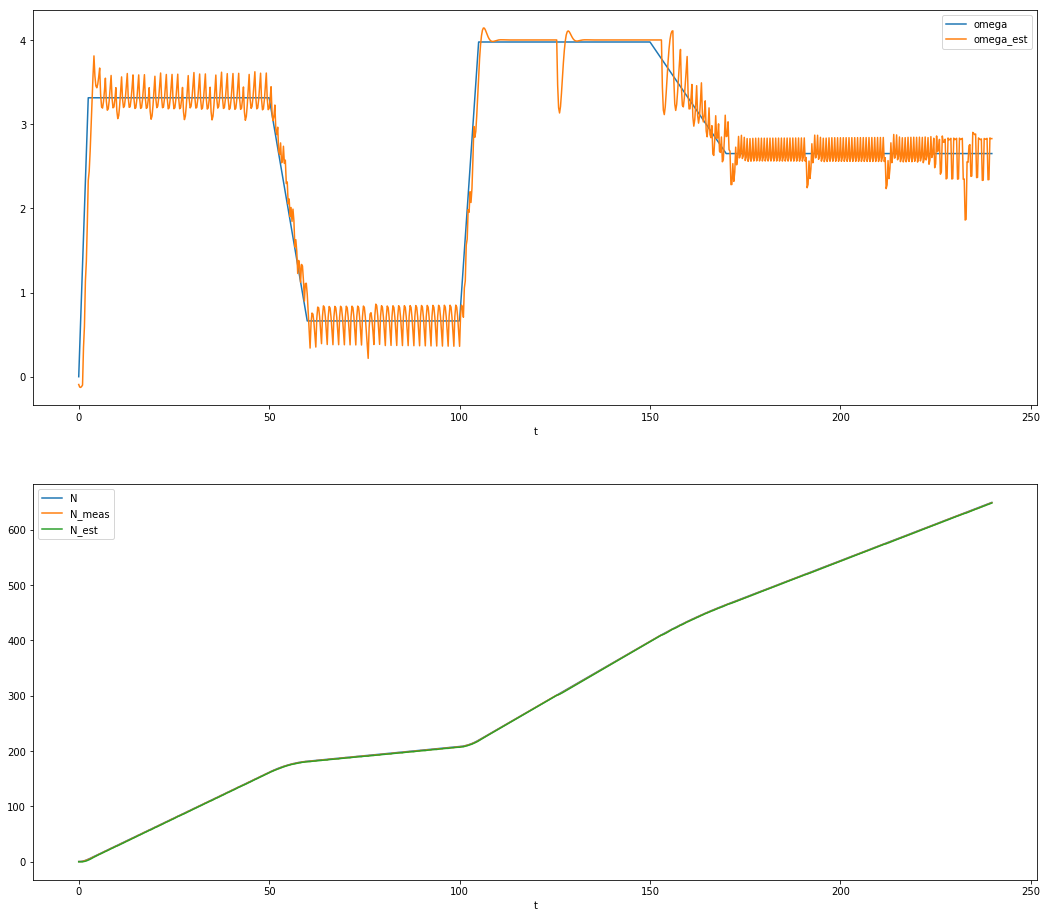

In [22]:
res = kalman1(sim_data.N_meas, DT,
              Q=np.array([[4.03675328e-07, 1.00000000e-06], [1.54499966e-06, 1.00210324e-03]]),
              R=np.array([[2.88675075e-01]]))
kalman1_result = sim_data.assign(N_est=pd.Series(res[:, 0])).assign(omega_est=pd.Series(res[:, 1]))

fig, ax = plt.subplots(nrows=2, facecolor="white")
kalman1_result.plot(ax=ax[0], x='t', y="omega")
kalman1_result.plot(ax=ax[0], x='t', y="omega_est")
kalman1_result.plot(ax=ax[1], x='t', y="N")
kalman1_result.plot(ax=ax[1], x="t", y="N_meas")
kalman1_result.plot(ax=ax[1], x="t", y="N_est")